# GENIE Search Analysis

This notebook performs set operations to determine matches between normalized variants from GENIE and normalized variants from CIViC, Molecular Oncology Almanac, and ClinVar.

### Prerequisites
The following notebook must be run before running this analysis: 

- `genie/pre_variant_analysis/genie_pre_variant_analysis.ipynb`

This notebook uses `data_mutations_extended.txt` from Synapse. You will need to create an account to download data from [here](https://www.synapse.org/#!Synapse:syn51355986). This notebook expects the `data_mutations_extended.txt` to be in the `pre_variant_analysis` directory.

In [1]:
# Import relevant libraries
import ndjson
import numpy as np
import pandas as pd
from pathlib import Path
import gzip

## Load Data (CIViC, Molecular Oncology Almanac, ClinVar, GENIE)

In [2]:
# Load normalized variants for CIViC
civic_variants = pd.read_csv(
    "../../civic/variation_analysis/able_to_normalize_queries.csv", sep="\t"
)

In [3]:
# Load normalized variants for MOA
moa_variants = pd.read_csv(
    "../../moa/feature_analysis/able_to_normalize_queries.csv", sep="\t"
)

In [4]:
# Load normalized variants for ClinVar
with gzip.open("../../clinvar/output-variation_identity-vrs-1.3.ndjson.gz", "rb") as f:
    records = ndjson.load(f)

clinvar_variants = pd.json_normalize(records)

In [5]:
# Get GENIE variant data
genie_variants_df = pd.read_csv(
    "../pre_variant_analysis/variation_normalizer_output/genie_variants_df.csv",
    sep="\t",
)
genie_variants_df.shape

(1432052, 12)

## Normalized Genomic and Protein GENIE variants 
Due to GENIE licenses, please run the analysis notebook in `genie/pre_variant_analysis` to generate the datasets below.

In [6]:
genie_genomic_normalized = pd.read_csv(
    "../pre_variant_analysis/variation_normalizer_output/able_to_normalize_genomic_queries.csv",
    sep="\t",
)

In [7]:
genie_protein_normalized = pd.read_csv(
    "../pre_variant_analysis/variation_normalizer_output/able_to_normalize_protein_queries.csv",
    sep="\t",
)

## Create Output Directory

In [8]:
path = Path("variant_analysis_output")
path.mkdir(exist_ok=True)

## Variant-Level Analysis
In this section we perform set intersections to determine how many normalized variants from GENIE match to MOA, CIViC, and ClinVar.

In [9]:
# Helper functions
def create_var_patient_data(filename: str, data: list) -> None:
    """Write variant/patient data to a file
    :param filename: The file to write to
    :param data: A list of variants or patients
    """
    with open(filename, "w") as f:
        for match in data:
            f.write(match + "\n")


def set_intersection(genie: list, kb: list) -> set:
    """Intersect GENIE variants with variants from different knowledgebases
    :param genie: A list of GENIE variants
    :param kb: A list of variants from a knowledgebase
    :return: set of common variants
    """
    return set(genie).intersection(kb)


def var_analysis(genie: list, kb: list, filename: str) -> tuple:
    """Perform set intersection, write to file for variant analysis
    :param genie: A list of GENIE variants
    :param kb: A list of variants from a knowledgebase
    :param filename: The file to write to
    :return: A tuple containing a list of shared variants, and the length of the list
    """
    match = set_intersection(genie, kb)
    create_var_patient_data(filename, list(match))
    return match, len(match)


def is_var_in_kb(var: str, kb: set) -> bool:
    """Check if a variant is in a knowledgebase
    :param var: A variant
    :param kb: A set of variants
    :return: True if variant is in knowledgebase
    """
    return var in kb

### MOA

In [10]:
# Intersect normalized GENIE protein variants with normalized MOA protein variants
genie_moa_match = var_analysis(
    genie_protein_normalized["vrs_id"].to_list(),
    set(moa_variants["vrs_id"].to_list()),
    "variant_analysis_output/genie_moa_match.txt",
)
f"The number of matched protein variants in MOA is: {genie_moa_match[1]}"

'The number of matched protein variants in MOA is: 122'

### CIViC

In [11]:
# Intersect normalized GENIE genomic variants with normalized CIViC variants
genie_civic_match_genomic = var_analysis(
    genie_genomic_normalized["vrs_id"].to_list(),
    set(civic_variants["vrs_id"].to_list()),
    "variant_analysis_output/genie_civic_match_genomic.txt",
)
f"The number of matched genomic variants in CIViC is: {genie_civic_match_genomic[1]}"

'The number of matched genomic variants in CIViC is: 203'

In [12]:
# Intersect normalized GENIE protein variants with normalized CIViC variants
genie_civic_match_protein = var_analysis(
    genie_protein_normalized["vrs_id"].to_list(),
    set(civic_variants["vrs_id"].to_list()),
    "variant_analysis_output/genie_civic_match_protein.txt",
)
f"The number of matched protein variants in CIViC is: {genie_civic_match_protein[1]}"

'The number of matched protein variants in CIViC is: 967'

In [13]:
# Inspect union of GENIE genomic and protein variants
civic_genie_union = genie_civic_match_genomic[0].union(genie_civic_match_protein[0])
create_var_patient_data(
    "variant_analysis_output/genie_civic_match_union.txt", civic_genie_union
)
f"The number of matched variants in CIViC is: {len(civic_genie_union)}"

'The number of matched variants in CIViC is: 1170'

### ClinVar

In [14]:
# Intersect normalized GENIE genomic variants with normalized ClinVar variants
genie_clinvar_match_genomic = var_analysis(
    genie_genomic_normalized["vrs_id"].to_list(),
    set(clinvar_variants["out._id"].to_list()),
    "variant_analysis_output/genie_clinvar_match_genomic.txt",
)
f"The number of matched genomic variants in ClinVar is: {genie_clinvar_match_genomic[1]}"

'The number of matched genomic variants in ClinVar is: 94300'

In [15]:
# Intersect normalized GENIE protein variants with normalized ClinVar variants
genie_clinvar_match_protein = set_intersection(
    genie_protein_normalized["vrs_id"].to_list(),
    set(clinvar_variants["out._id"].to_list()),
)
f"The number of matched protein variants in ClinVar is: {len(genie_clinvar_match_protein)}"

'The number of matched protein variants in ClinVar is: 0'

## Patient-Level Analysis
In this section we summarize variant matching at the patient level, with >= 1 shared variant counting as a match.

### Filter to include normalized genomic and protein variants

In [16]:
# Helper function - create dataframes with vrs_ids for genomic and protein variants
def get_vrs_ids(df: pd.DataFrame, col_name: str) -> pd.DataFrame:
    """Given a list of GENIE variants, add a column containing the VRS IDs
    :param df: A dataframe containing the VRS IDs for each variant
    :param col_name: Indicates if genomic or protein variants will be added
    :return: The updated genie_variants dataframe
    """
    genie_variants_mapping = {}
    for row in df.itertuples(index=False):
        if row.query not in genie_variants_mapping:
            genie_variants_mapping[row.query] = row.vrs_id

    queries = genie_variants_df[col_name].to_list()
    vrs_ids_list = [genie_variants_mapping.get(query, np.nan) for query in queries]

    key = "vrs_id_genomic" if col_name == "coordinates" else "vrs_id_protein"
    genie_variants_df[key] = vrs_ids_list
    return genie_variants_df[genie_variants_df[key].notna()]

In [17]:
genie_variants_genomic = get_vrs_ids(genie_genomic_normalized, "coordinates")

In [18]:
genie_variants_protein = get_vrs_ids(genie_protein_normalized, "free_text_p_short")

In [19]:
# Add columns indicating which variants are in which knowledgebase
genie_variants_df["in_civic_genomic"] = genie_variants_df["vrs_id_genomic"].map(
    lambda x: is_var_in_kb(x, genie_civic_match_genomic[0])
)
genie_variants_df["in_clinvar"] = genie_variants_df["vrs_id_genomic"].map(
    lambda x: is_var_in_kb(x, genie_clinvar_match_genomic[0])
)
genie_variants_df["in_civic_protein"] = genie_variants_df["vrs_id_protein"].map(
    lambda x: is_var_in_kb(x, genie_civic_match_protein[0])
)
genie_variants_df["in_moa"] = genie_variants_df["vrs_id_protein"].map(
    lambda x: is_var_in_kb(x, genie_moa_match[0])
)

In [20]:
# Helper function - create patient dictionary
def get_patient_vars(df: pd.DataFrame, var_type: str) -> dict:
    """Create a dictionary reporting the variants a patient has
    :param df: A dataframe with GENIE genomic or protein variants
    :param var_type: Genomic or protein
    :return: A dictionary of patient variants
    """
    patient_dict = dict()
    for row in df.itertuples(index=False):
        key = row.Tumor_Sample_Barcode
        var = row.vrs_id_genomic if var_type == "genomic" else row.vrs_id_protein
        if key in patient_dict:
            curr = patient_dict[key]
            if not pd.isna(var):
                curr.append(var)
            patient_dict[key] = curr
        else:
            if not pd.isna(var):
                patient_dict[key] = [var]
    return patient_dict

In [21]:
# Create genomic variants patient dictionary
pvd_genomic = get_patient_vars(genie_variants_genomic, "genomic")

In [22]:
# Create protein variants patient dictionary
pvd_protein = get_patient_vars(genie_variants_protein, "protein")

In [23]:
# Patient Analysis Helper Function
def patient_matching(patient_dict: dict, var_set: set, filename: str) -> tuple:
    """Perform patient matching for a given source
    :param patient_dict: A dictionary of patient variants
    :param var_set: A set of common variants
    :param filename: The file to write to
    :return: A tuple containing a list of patients with common variants, and the number of patients in that list
    """
    count = 0
    patients = []
    for key in patient_dict:
        isect = set(patient_dict[key]).intersection(var_set)
        if isect:
            count += 1
            patients.append(key)
    create_var_patient_data(filename, patients)
    return count, patients

### MOA

In [24]:
moa_match = patient_matching(
    pvd_protein, genie_moa_match[0], "variant_analysis_output/moa_patient_match.txt"
)
f"There are {moa_match[0]} patients with matching protein variant data in MOA"

'There are 41828 patients with matching protein variant data in MOA'

### CIViC

In [25]:
civic_protein_match = patient_matching(
    pvd_protein,
    genie_civic_match_protein[0],
    "variant_analysis_output/civic_protein_patient_match.txt",
)
f"There are {civic_protein_match[0]} patients with matching protein variant data in CIViC"

'There are 84861 patients with matching protein variant data in CIViC'

In [26]:
civic_genomic_match = patient_matching(
    pvd_genomic,
    genie_civic_match_genomic[0],
    "variant_analysis_output/civic_genomic_patient_match.txt",
)
f"There are {civic_genomic_match[0]} patients with matching genomic variant data in CIViC"

'There are 853 patients with matching genomic variant data in CIViC'

In [27]:
# Compute number of patients with both genomic and protein variant overlap
len(set(civic_genomic_match[1]).intersection(set(civic_protein_match[1])))

272

### ClinVar

In [28]:
genie_clinvar_patient_match = patient_matching(
    pvd_genomic,
    genie_clinvar_match_genomic[0],
    "variant_analysis_output/clinvar_patient_match.txt",
)
f"There are {genie_clinvar_patient_match[0]} patients with matching genomic variant data in ClinVar"

'There are 127103 patients with matching genomic variant data in ClinVar'

## Variant Counts per Patient
Compute the average number of genomic and protein variants per patient.

In [29]:
def get_avg_vars_per_patient(var_dict: dict) -> float:
    """Return the average number of variants per patient
    :param var_dict: A dictionary of patient variants
    :return: The average number of normalized variants
    """
    counts = [len(var_dict[k]) for k in var_dict]
    return sum(counts) / len(counts)

In [30]:
# Normalized average, genomic
get_avg_vars_per_patient(pvd_genomic)

8.703645296719163

In [31]:
# Normalized average, protein
get_avg_vars_per_patient(pvd_protein)

7.9632307941219915

In [32]:
# Average number of normalized variants per patient
normalized_variants_df = genie_variants_df[
    ~genie_variants_df["vrs_id_genomic"].isna()
    | ~genie_variants_df["vrs_id_protein"].isna()
]
group_by_tsb = list(normalized_variants_df.groupby("Tumor_Sample_Barcode").size())
sum(group_by_tsb) / len(group_by_tsb)

8.860833124843634

In [33]:
def get_kb_avg_vars_per_patient(df: pd.DataFrame) -> float:
    """Compute the average number of variants per patient given a knowledgebase
    :param df: The filtered dataframe of patient variants
    :return: The average number of variants
    """
    n_variants = list(df.groupby("Tumor_Sample_Barcode").size())
    return round(sum(n_variants) / len(n_variants), 2), len(n_variants)

In [34]:
# Average number of total variants per patient
get_kb_avg_vars_per_patient(genie_variants_df)[0]

9.75

In [35]:
# Normalized matched genomic variants per patient in CIViC
genie_df_civic_genomic = genie_variants_df[genie_variants_df["in_civic_genomic"]]
civic_genomic_match = get_kb_avg_vars_per_patient(genie_df_civic_genomic)
civic_genomic_match[0]

1.01

In [36]:
# Normalized matched protein variants per patient in CIViC
genie_df_civic_protein = genie_variants_df[genie_variants_df["in_civic_protein"]]
civic_protein_match = get_kb_avg_vars_per_patient(genie_df_civic_protein)
civic_protein_match[0]

1.38

In [37]:
# Normalized matched patient variants across CIViC
genie_df_civic = genie_variants_df[
    (genie_variants_df["in_civic_genomic"]) | (genie_variants_df["in_civic_protein"])
]
civic_match = get_kb_avg_vars_per_patient(genie_df_civic)
civic_match[0]

1.38

In [38]:
# Normalized matched protein variants per patient in MOA
genie_df_moa = genie_variants_df[genie_variants_df["in_moa"]]
moa_protein_match = get_kb_avg_vars_per_patient(genie_df_moa)
moa_protein_match[0]

1.1

In [39]:
# Normalized matched genomic variants per patient in ClinVar
genie_df_clinvar = genie_variants_df[genie_variants_df["in_clinvar"]]
clinvar_genomic_match = get_kb_avg_vars_per_patient(genie_df_clinvar)
clinvar_genomic_match[0]

3.22

In [40]:
# Normalized matching across knowlegebases, genomic
genie_df_genomic_combined = genie_variants_df[
    (genie_variants_df["in_civic_genomic"]) | (genie_variants_df["in_clinvar"])
]
genomic_combined_match = get_kb_avg_vars_per_patient(genie_df_genomic_combined)
genomic_combined_match[0]

3.22

In [41]:
# Normalized matching across knowlegebases, protein
genie_df_protein_combined = genie_variants_df[
    (genie_variants_df["in_civic_protein"]) | (genie_variants_df["in_moa"])
]
protein_combined_match = get_kb_avg_vars_per_patient(genie_df_protein_combined)
protein_combined_match[0]

1.39

In [42]:
# Normalized matching across all knowledgebases
genie_df_filtered = genie_variants_df[
    (genie_variants_df["in_civic_protein"])
    | (genie_variants_df["in_moa"])
    | (genie_variants_df["in_civic_genomic"])
    | (genie_variants_df["in_clinvar"])
]
filtered_match = get_kb_avg_vars_per_patient(genie_df_filtered)
filtered_match[0]

3.25

## Summary Statistics

In [43]:
# Number of unique patients in GENIE dataframe
total_patients = genie_variants_df["Tumor_Sample_Barcode"].nunique()
total_patients

146857

In [44]:
# Number of patients with at least 1 normalized variant
normalized_patients = normalized_variants_df["Tumor_Sample_Barcode"].nunique()
normalized_patients

143892

In [45]:
# Number of patients with at least 1 normalized variant and a match to a knowledgebase
matching_patients = genie_df_filtered["Tumor_Sample_Barcode"].nunique()
matching_patients

128397

In [46]:
# Table 1 - Variant Counts
summary_df_var = pd.DataFrame(columns=["Protein", "Genomic"])
summary_df_var.loc["# of Unique GENIE Variants"] = [
    genie_variants_df["free_text_p_short"].nunique(),
    genie_variants_df["coordinates"].nunique(),
]
summary_df_var.loc["# of Able to Normalize GENIE Queries"] = [
    len(genie_protein_normalized.index),
    len(genie_genomic_normalized.index),
]
summary_df_var.loc["# of Unique GENIE VRS IDs"] = [
    normalized_variants_df["vrs_id_protein"].nunique(),
    normalized_variants_df["vrs_id_genomic"].nunique(),
]
summary_df_var.loc["# of Unique Normalized GENIE Variants in CIViC"] = [
    genie_df_civic_protein["vrs_id_protein"].nunique(),
    genie_df_civic_genomic["vrs_id_genomic"].nunique(),
]
summary_df_var.loc["# of Unique Normalized Protein GENIE Variants in MOA"] = [
    genie_df_moa["vrs_id_protein"].nunique(),
    0,
]
summary_df_var.loc["# of Unique Normalized Genomic GENIE Variants in ClinVar"] = [
    0,
    genie_df_clinvar["vrs_id_genomic"].nunique(),
]

In [47]:
summary_df_var

,Protein,Genomic
# of Unique GENIE Variants,662149,647541
# of Able to Normalize GENIE Queries,566804,646946
# of Unique GENIE VRS IDs,565824,646696
# of Unique Normalized GENIE Variants in CIViC,967,203
# of Unique Normalized Protein GENIE Variants in MOA,122,0
# of Unique Normalized Genomic GENIE Variants in ClinVar,0,94300


In [48]:
# Helper function
def compute_percent(n: int, d: int) -> str:
    """Format percentage
    :param n, d: Two integers
    :return: A string reporting the percentage"""
    percent = round(100 * n / d, 1)
    return percent


# Table 2 - Patient Matching. The percentages are computed using the total number of patients in the GENIE dataset.
summary_df_patient = pd.DataFrame(columns=["Protein", "Genomic", "Protein or Genomic"])
summary_df_patient.loc["All Sources"] = [
    compute_percent(protein_combined_match[1], total_patients),
    compute_percent(genomic_combined_match[1], total_patients),
    compute_percent(filtered_match[1], total_patients),
]
summary_df_patient.loc["MOA"] = [
    compute_percent(moa_protein_match[1], total_patients),
    0,
    compute_percent(moa_protein_match[1], total_patients),
]
summary_df_patient.loc["ClinVar"] = [
    0,
    compute_percent(clinvar_genomic_match[1], total_patients),
    compute_percent(clinvar_genomic_match[1], total_patients),
]
summary_df_patient.loc["CIViC"] = [
    compute_percent(civic_protein_match[1], total_patients),
    compute_percent(civic_genomic_match[1], total_patients),
    compute_percent(civic_match[1], total_patients),
]

In [49]:
summary_df_patient

,Protein,Genomic,Protein or Genomic
All Sources,58.4,86.6,87.4
MOA,28.5,0.0,28.5
ClinVar,0.0,86.5,86.5
CIViC,57.8,0.6,58.2


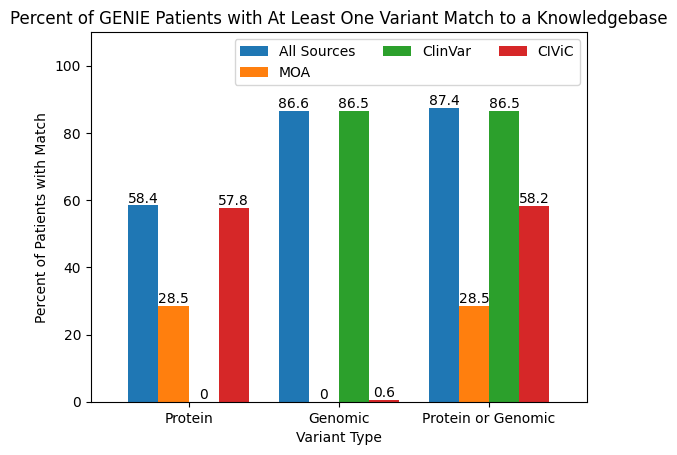

In [50]:
# Create Grouped Bar Plot for Table 2
summary_df_patient = summary_df_patient.T
patient_plot = summary_df_patient.plot.bar(rot=0, width=0.8)
for container in patient_plot.containers:
    patient_plot.bar_label(container)
patient_plot.legend(loc="upper right", ncols=3)
patient_plot.set_ylim(0, 110)
patient_plot.set_ylabel("Percent of Patients with Match")
patient_plot.set_xlabel("Variant Type")
patient_plot.set_title(
    "Percent of GENIE Patients with At Least One Variant Match to a Knowledgebase"
)
patient_plot.figure.savefig("genie_patient_matching.png", bbox_inches="tight")

In [51]:
# Table 3 - Average Variants Per Patient. This average is calculated using the number of patients from each filtering category.
summary_df_avg = pd.DataFrame(columns=["Protein", "Genomic"])
summary_df_avg.loc["Average # of Total Variants per Patient"] = [
    get_kb_avg_vars_per_patient(
        genie_variants_df[genie_variants_df["free_text_p_short"].notna()]
    )[0],
    get_kb_avg_vars_per_patient(
        genie_variants_df[genie_variants_df["coordinates"].notna()]
    )[0],
]
summary_df_avg.loc["Average # of Normalized Variants per Patient"] = [
    get_kb_avg_vars_per_patient(
        normalized_variants_df[normalized_variants_df["vrs_id_protein"].notna()]
    )[0],
    get_kb_avg_vars_per_patient(
        normalized_variants_df[normalized_variants_df["vrs_id_genomic"].notna()]
    )[0],
]
summary_df_avg.loc["Average # of Normalized Variants per Patient in Clinvar"] = [
    0,
    clinvar_genomic_match[0],
]
summary_df_avg.loc["Average # of Normalized Variants per Patient in MOA"] = [
    moa_protein_match[0],
    0,
]
summary_df_avg.loc["Average # of Normalized Variants per Patient in CIViC"] = [
    civic_protein_match[0],
    civic_genomic_match[0],
]

In [52]:
summary_df_avg

,Protein,Genomic
Average # of Total Variants per Patient,9.60,8.71
Average # of Normalized Variants per Patient,7.96,8.70
Average # of Normalized Variants per Patient in Clinvar,0.00,3.22
Average # of Normalized Variants per Patient in MOA,1.10,0.00
Average # of Normalized Variants per Patient in CIViC,1.38,1.01
